In [1]:
import math
import torch
from torch import Tensor
from torch import nn
import torch.nn.functional as F
from typing import Optional, List
import torchvision.transforms as transforms
from PIL import Image
from torchvision.models import resnet50,ResNet50_Weights
from torch import Tensor
from matplotlib import cm
from torchvision.transforms.functional import to_pil_image
import os  

In [2]:
def process_image_withhooks(img_path, model_weights=ResNet50_Weights.DEFAULT):  
    """  
    处理图片并计算特征和梯度的加权值donations_values  

    Args:  
        img_path (str): 输入图片的路径  
        model_weights: 模型的预训练权重，默认为ResNet50的默认权重  

    Returns:  
        tensor: shape (num_classes,) 的 tensor，表示各个类别的donations_values  
    """  
    # 定义预处理步骤  
    test_transform = transforms.Compose([  
        transforms.Resize(512),  
        transforms.ToTensor(),  
        transforms.Normalize(  
            mean=[0.485, 0.456, 0.406],  
            std=[0.229, 0.224, 0.225]  
        )  
    ])  

    # 获取设备  
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  

    # 初始化模型  
    model = resnet50(weights=model_weights).eval().to(device)  

    # print(f"try to open image, path：{img_path}")  
    if not img_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):  
        print(f"跳过非图片文件：{img_path}")  
        return None  

    # 加载图片  
    img_pil = Image.open(img_path)  

    # 预处理图片  
    input_tensor = test_transform(img_pil).unsqueeze(0).to(device)  

    # 定义前向hook  
    def forward_hook(module, inp, outp):  
        feature_map.append(outp)  

    # 定义反向hook  
    def backward_hook(module, inp, outp):  
        grad.append(outp)  

    # 初始化容器  
    feature_map = []  
    grad = []  

    # 注册hook  
    hook_layer = model.layer4[-1]  
    hook_handle = hook_layer.register_forward_hook(forward_hook)  
    grad_hook_handle = hook_layer.register_full_backward_hook(backward_hook)  

    try:  
        # 前向传播  
      
        out = model(input_tensor)  
        cls_idx = torch.argmax(out).item()  
        # 计算预测类别分数  
        score = out[:, cls_idx].sum()  

        # 反向传播  
        model.zero_grad()  
        score.backward(retain_graph=False)  # 减少内存占用  

        # 获取特征和梯度  
        weights = grad[0][0].squeeze(0).mean(dim=(1, 2))  #GAP(a)
        mean_values = feature_map[0].squeeze(0).mean(dim=(1, 2))  

        # 计算加权后的值  
        donations_values = mean_values * weights  
        # donations_values = mean_values

        return donations_values.detach().cpu(),weights.detach().cpu(),mean_values.detach().cpu()

    except Exception as e:  
        print(f"处理过程中出现错误：{e}")  
        return None  

    finally:  
        # 删除hook并清理数据  
        hook_handle.remove()  
        grad_hook_handle.remove()  
        feature_map.clear()  
        grad.clear()  

        # 删除GPU上的张量并释放内存  
        if input_tensor.is_cuda:  
            del input_tensor  
            torch.cuda.empty_cache()  

        if 'out' in locals():  
            del out  
        if 'score' in locals():  
            del score

In [3]:

# 配置PyTorch的内存分配参数，减少内存碎片  
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True' 

def process_batch_images(class_path, batch_size=8, device=None, limit_num=100):  
    """批量处理一个类别下的所有图片，并返回每张图片的donations_values、weights和mean_values列表  

    Args:  
        class_path (str): 类别图片的路径  
        batch_size (int): 批次大小，缺省值为8  
        device (str or torch.device, optional): 设备类型（"cpu" 或 "cuda"），缺省值为None，会自动检测  
        limit_num (int): 限制处理的图片数量，缺省值为100  

    Returns:  
        tuple: 包含三个列表，每个列表的元素是字典，字典包含图片路径和对应的值：  
            - donations_values_list (list): 每张图片的 {'img_path': str, 'donations_values': tensor} 列表  
            - weights_list (list): 每张图片的 {'img_path': str, 'weights': tensor} 列表  
            - mean_values_list (list): 每张图片的 {'img_path': str, 'mean_values': tensor} 列表  
    """  
    if device is None:  
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
    print()  
    print("使用设备：" + str(device))  
    print("分析目录：" + str(class_path))  

    # 初始化返回的三个列表  
    donations_values_list = []  
    weights_list = []  
    mean_values_list = []  

    # 获取图片文件路径列表  
    img_paths = [  
        os.path.join(class_path, f)  
        for f in os.listdir(class_path)  
        if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))  
    ]  

    # 计算总批次数  
    total_batches = len(img_paths) // batch_size  
    if len(img_paths) % batch_size != 0:  
        total_batches += 1  

    succeed_count = 0  # 记录成功处理的图片数量  

    # 分批次处理图片  
    for batch_idx in range(total_batches):  
        start = batch_idx * batch_size  
        end = min((batch_idx + 1) * batch_size, len(img_paths))  
        batch_paths = img_paths[start:end]  

        # 逐张处理图片以减少内存占用  
        for img_path in batch_paths:  
            if succeed_count >= limit_num:  
                print(f"已达到限制数量 {limit_num}，停止处理。")  
                break  

            try:  
                # 调用process_image_withhooks处理图片  
                result = process_image_withhooks(img_path)  

                if result is not None:  
                    donations_values, weights, mean_values = result  
                    # 将结果和图片路径组成字典，并添加到对应的列表中  
                    donations_values_list.append({'img_path': img_path, 'donations_values': donations_values})  
                    weights_list.append({'img_path': img_path, 'weights': weights})  
                    mean_values_list.append({'img_path': img_path, 'mean_values': mean_values})  
                    succeed_count += 1  

                    if succeed_count >= limit_num:  
                        print(f"已达到限制数量 {limit_num}，停止处理。")  
                        # 提前终止外层循环  
                        batch_idx = total_batches  # 强制退出外层循环  
                        break  

            except Exception as e:  
                print(f"处理 {img_path} 时发生错误：{str(e)}")  
                continue  

        # 检查是否需要提前终止外层循环  
        if succeed_count >= limit_num:  
            print(f"已达到限制数量 {limit_num}，停止处理。")  
            break  

    print(f"成功处理的图片总数：{succeed_count}")  
    return donations_values_list, weights_list, mean_values_list  

In [5]:
class_path1 = "dataset/n02105505/" #匈牙利牧羊犬  
class_path2 = "dataset/n02108089/" #拳师狗
class_path3 = "dataset/n02101006/" #戈登雪达犬

donations_values_list1, weights_list1, mean_values_list1 = process_batch_images(class_path1, batch_size=8,limit_num=50)  
donations_values_list2, weights_list2, mean_values_list2 = process_batch_images(class_path2, batch_size=8,limit_num=50) 
donations_values_list3, weights_list3, mean_values_list3 = process_batch_images(class_path3, batch_size=8,limit_num=50) 


使用设备：cuda
分析目录：dataset/n02105505/
已达到限制数量 50，停止处理。
已达到限制数量 50，停止处理。
成功处理的图片总数：50

使用设备：cuda
分析目录：dataset/n02108089/
已达到限制数量 50，停止处理。
已达到限制数量 50，停止处理。
成功处理的图片总数：50

使用设备：cuda
分析目录：dataset/n02101006/
已达到限制数量 50，停止处理。
已达到限制数量 50，停止处理。
成功处理的图片总数：50


In [6]:
# 访问第一张图片的路径和 weights
first_img_path = weights_list1[0]['img_path']
first_donations = weights_list1[0]['weights']

print(f"图片路径: {first_img_path}")
print(f"Donations Values: {first_donations}")

图片路径: dataset/n02105505/n02105505_37.jpg
Donations Values: tensor([ 1.5558e-05, -1.3199e-05,  1.3191e-04,  ..., -1.2246e-05,
         3.0057e-05, -3.9265e-05])


In [22]:
import numpy as np  
import torch  
from sklearn.cluster import KMeans  
from sklearn.decomposition import PCA  
from sklearn.preprocessing import StandardScaler  

def cluster_mixed_class_batches(donations_list1, donations_list2, donations_list3, n_clusters=2):  
    """混合处理三个类别的图片特征数据，进行标准化、降维和聚类，并关联图片路径与标签  

    Args:  
        donations_list1 (list): 第一个类别的数据列表，元素为字典 {'img_path': str, 'donations_values': tensor}  
        donations_list2 (list): 第二个类别的数据列表，元素为字典 {'img_path': str, 'donations_values': tensor}  
        donations_list3 (list): 第三个类别的数据列表，元素为字典 {'img_path': str, 'donations_values': tensor}  
        n_clusters (int, optional): K-means聚类簇数，缺省为2  

    Returns:  
        tuple: 包含以下内容：  
            - cluster_labels (np.ndarray): 聚类标签，形状 (num_samples,)  
            - cluster_centers (np.ndarray): 聚类中心，形状 (n_clusters, n_components)  
            - principal_components (np.ndarray): 降维后的数据，形状 (num_samples, n_components)  
            - metadata (list): 三元组列表，每个元素为 (img_path, original_class_label, cluster_label)  
    """  
    # 提取所有图片路径和原始类别标签  
    img_paths = []  
    original_labels = []  

    # 提取第一个类别的数据（标签为0）  
    data_list1 = []  
    for item in donations_list1:  
        data_list1.append(item['mean_values'].cpu().numpy())  
        img_paths.append(item['img_path'])  
        original_labels.append(0)  # 原始类别标签0  

    # 提取第二个类别的数据（标签为1）  
    data_list2 = []  
    for item in donations_list2:  
        data_list2.append(item['mean_values'].cpu().numpy())  
        img_paths.append(item['img_path'])  
        original_labels.append(1)  # 原始类别标签1  

    # 提取第三个类别的数据（标签为2）  
    data_list3 = []  
    for item in donations_list3:  
        data_list3.append(item['mean_values'].cpu().numpy())  
        img_paths.append(item['img_path'])  
        original_labels.append(2)  # 原始类别标签2  

    # 合并数据并转换为NumPy数组  
    combined_data = np.vstack(data_list1 + data_list2 + data_list3)  
    original_labels = np.array(original_labels)  

    # 数据预处理：标准化  
    scaler = StandardScaler()  
    scaled_data = scaler.fit_transform(combined_data)  

    # 降维至2维（可根据需求调整）  
    pca = PCA(n_components=2)  
    principal_components = pca.fit_transform(scaled_data)  

    # K-means聚类  
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)  
    cluster_labels = kmeans.fit_predict(principal_components)  
    cluster_centers = kmeans.cluster_centers_  

    # 构建元数据列表：关联图片路径、原始类别、聚类标签  
    metadata = [  
        (img_paths[i], original_labels[i], cluster_labels[i])  
        for i in range(len(img_paths))  
    ]  

    return cluster_labels, cluster_centers, principal_components, metadata

In [23]:
# 聚类分析——三种指标，还要修改函数
# cluster_labels, centers, pca_data, metadata = cluster_mixed_class_batches(donations_values_list1, donations_values_list2,donations_values_list3, n_clusters=3)  
# cluster_labels, centers, pca_data, metadata = cluster_mixed_class_batches(weights_list1,
#                             weights_list2,weights_list3, n_clusters=3)  
cluster_labels, centers, pca_data, metadata = cluster_mixed_class_batches(mean_values_list1,
                            mean_values_list2,mean_values_list3, n_clusters=3)  

# 打印第一条元数据
print(metadata[0])
print(metadata[1])
print(metadata[2])

('dataset/n02105505/n02105505_37.jpg', 0, 0)
('dataset/n02105505/n02105505_30.jpg', 0, 2)
('dataset/n02105505/n02105505_93.jpg', 0, 0)


In [24]:
import numpy as np
from collections import defaultdict

def calculate_iou(metadata):
    """计算原始类别与聚类簇的IoU，输出合并统计表并逐类显示IoU
    
    Args:
        metadata (list): 三元组列表，元素为 (img_path, original_class_label, cluster_label)
        
    Returns:
        float: 所有类别的平均IoU值
    """
    # 提取标签并生成唯一标识
    original_labels = [m[1] for m in metadata]
    cluster_labels = [m[2] for m in metadata]
    
    unique_classes = sorted(np.unique(original_labels))
    unique_clusters = sorted(np.unique(cluster_labels))
    
    # 生成易读名称
    class_names = [f"class{c}" for c in unique_classes]
    cluster_names = [f"cluster{c}" for c in unique_clusters]
    all_headers = cluster_names + ["Total"]

    # 构建交叉统计表
    cross_table = defaultdict(lambda: defaultdict(int))
    for _, o_label, c_label in metadata:
        cross_table[f"class{o_label}"][f"cluster{c_label}"] += 1

    # 添加总计列
    for cls in class_names:
        cross_table[cls]["Total"] = sum(cross_table[cls].values())

    # 添加总计行
    total_row = defaultdict(int)
    for cluster in cluster_names:
        total_row[cluster] = sum(cross_table[cls][cluster] for cls in class_names)
    total_row["Total"] = sum(total_row.values())
    cross_table["Total"] = total_row

    # 打印合并统计表
    def format_row(values, width=12):
        return "|".join([f"{v:^{width}}" for v in values])

    # 表头
    print("\n" + "="*60)
    print("[交叉统计表] 原始类别 vs 聚类簇分布".center(60))
    print("-"*60)
    headers = ["Category"] + all_headers
    print(format_row(headers))
    print("-"*60)

    # 数据行
    for cls in class_names:
        row = [cls] + [cross_table[cls][c] for c in cluster_names] + [cross_table[cls]["Total"]]
        print(format_row(map(str, row)))

    # 总计行
    total_values = ["Total"] + [cross_table["Total"][c] for c in cluster_names] + [cross_table["Total"]["Total"]]
    print("-"*60)
    print(format_row(map(str, total_values)))
    print("="*60)

    # 计算逐类IoU
    print("\nIoU计算结果：")
    iou_list = []
    for cls in class_names:
        class_total = cross_table[cls]["Total"]
        max_iou = 0.0
        best_cluster = None
        
        for cluster in cluster_names:
            intersection = cross_table[cls][cluster]
            cluster_total = cross_table["Total"][cluster]
            union = class_total + (cluster_total - intersection)
            
            if union == 0:
                iou = 0.0
            else:
                iou = intersection / union
                
            if iou > max_iou:
                max_iou = iou
                best_cluster = cluster

        # 打印单个类别结果
        print(f"  {cls}:")
        print(f"    ├── 最佳匹配簇: {best_cluster}")
        print(f"    ├── 交集样本数: {cross_table[cls][best_cluster]}")
        print(f"    ├── 类别总样本: {class_total}")
        print(f"    ├── 簇总样本数: {cross_table['Total'][best_cluster]}")
        print(f"    └── IoU: {max_iou:.4f}")
        
        iou_list.append(max_iou)

    # 最终平均值
    avg_iou = np.mean(iou_list)
    print("\n" + "="*60)
    print(f"平均 IoU: {avg_iou:.4f}".center(60))
    print("="*60)
    
   

In [25]:
calculate_iou(metadata)


                   [交叉统计表] 原始类别 vs 聚类簇分布                    
------------------------------------------------------------
  Category  |  cluster0  |  cluster1  |  cluster2  |   Total    
------------------------------------------------------------
   class0   |     29     |     0      |     21     |     50     
   class1   |     32     |     12     |     6      |     50     
   class2   |     32     |     6      |     12     |     50     
------------------------------------------------------------
   Total    |     93     |     18     |     39     |    150     

IoU计算结果：
  class0:
    ├── 最佳匹配簇: cluster2
    ├── 交集样本数: 21
    ├── 类别总样本: 50
    ├── 簇总样本数: 39
    └── IoU: 0.3088
  class1:
    ├── 最佳匹配簇: cluster0
    ├── 交集样本数: 32
    ├── 类别总样本: 50
    ├── 簇总样本数: 93
    └── IoU: 0.2883
  class2:
    ├── 最佳匹配簇: cluster0
    ├── 交集样本数: 32
    ├── 类别总样本: 50
    ├── 簇总样本数: 93
    └── IoU: 0.2883

                       平均 IoU: 0.2951                       


In [26]:
import numpy as np  
import matplotlib.pyplot as plt  
from matplotlib.lines import Line2D  

def visualize_clusters(principal_components, metadata, cluster_centers, figsize=(14, 10), point_size=100, alpha=0.8):  
    """  
    增强版聚类可视化函数  
    
    参数:  
        principal_components (np.ndarray): 降维后的二维数据点，形状为(num_samples, 2)  
        metadata (list): 包含(img_path, original_class_label, cluster_label)的三元组列表  
        cluster_centers (np.ndarray): 聚类中心坐标，形状为(n_clusters, 2)  
        figsize (tuple, optional): 图形的大小，默认为(14, 10)  
        point_size (int, optional): 数据点的大小，默认为100  
        alpha (float, optional): 数据点的透明度，默认为0.8  
    """  
    # 提取标签数据  
    original_labels = np.array([m[1] for m in metadata])  
    cluster_labels = np.array([m[2] for m in metadata])  
    
    # 获取唯一标签  
    unique_clusters = np.unique(cluster_labels)  
    unique_classes = np.unique(original_labels)  
    n_clusters, n_classes = len(unique_clusters), len(unique_classes)  
    
    # 智能颜色选择  
    if n_clusters <= 10:  
        colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))  
    elif n_clusters <= 20:  
        colors = plt.cm.tab20(np.linspace(0, 1, n_clusters))  
    else:  
        colors = plt.cm.gist_rainbow(np.linspace(0, 1, n_clusters))  
    
    # 扩展形状库  
    base_markers = ['o', 's', '^', 'D', 'v', 'p', '*', 'h', 'H', '+', 'x', 'd', '|', '_']  
    markers = (base_markers * ((n_classes // len(base_markers)) + 1))[:n_classes]  
    
    # 创建画布  
    plt.figure(figsize=figsize)  
    
    # 绘制数据点  
    for cluster_idx, cluster in enumerate(unique_clusters):  
        cluster_mask = (cluster_labels == cluster)  
        for cls_idx, cls in enumerate(unique_classes):  
            mask = cluster_mask & (original_labels == cls)  
            if np.any(mask):  # 只绘制有数据的组合  
                plt.scatter(  
                    principal_components[mask, 0],  
                    principal_components[mask, 1],  
                    color=colors[cluster_idx],  
                    marker=markers[cls_idx],  
                    alpha=alpha,  
                    edgecolors='w',  
                    linewidths=0.8,  
                    s=point_size,  
                    label=f"Cluster {cluster}, Class {cls}"  # 修改图例标签为组合形式  
                )  

    # 突出显示聚类中心  
    for i, center in enumerate(cluster_centers):  
        plt.scatter(  
            center[0], center[1],  
            marker="X", s=350,  
            color=colors[i],  
            edgecolors="k",  
            linewidth=2,  
            zorder=10  # 确保中心点在顶层  
        )  

    # 创建组合图例  
    legend_elements = []  
    
    # 为每个 (cluster, class) 组合创建图例  
    for cluster_idx, cluster in enumerate(unique_clusters):  
        for cls_idx, cls in enumerate(unique_classes):  
            legend_elements.append(  
                Line2D([0], [0],  
                       marker=markers[cls_idx],  
                       color='w',  
                       label=f'Cluster {cluster}, Class {cls}',  
                       markerfacecolor=colors[cluster_idx],  
                       markersize=12)  
            )  

    # 添加中心点图例  
    legend_elements.append(  
        Line2D([0], [0],  
               marker='X',  
               color='w',  
               label='Cluster Centers',  
               markerfacecolor='gray',  
               markersize=12)  
    )  

    # 美化图例和标签  
    plt.legend(  
        handles=legend_elements,  
        loc='upper right',  
        bbox_to_anchor=(1.25, 1),  
        title="Legend",  
        fontsize=10,  
        framealpha=0.9  
    )  
    
    plt.xlabel("Principal Component 1", fontsize=12)  
    plt.ylabel("Principal Component 2", fontsize=12)  
    plt.title(  
        f"Cluster Visualization\n"  
        f"(Colors: {n_clusters} Clusters | Shapes: {n_classes} Classes)"  
    )  
    plt.grid(alpha=0.3)  
    plt.tight_layout()  
    plt.show()

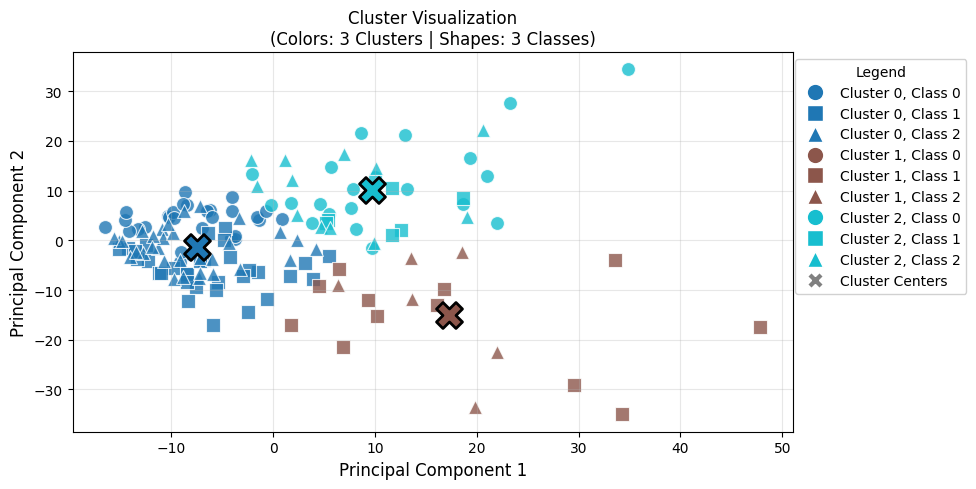

In [27]:
# 调用可视化函数
visualize_clusters(
    principal_components=pca_data,
    metadata=metadata,
    cluster_centers=centers,
    figsize=(10, 5)
)

In [13]:
import math  
import random  
import matplotlib.pyplot as plt  

def visualize_cluster_samples(metadata, max_samples_per_cluster=8):  
    # 按聚类分组  
    cluster_dict = {}  
    for img_path, original_label, cluster_label in metadata:  
        if cluster_label not in cluster_dict:  
            cluster_dict[cluster_label] = []  
        cluster_dict[cluster_label].append((img_path, original_label))  

    # 计算聚类数量  
    n_clusters = len(cluster_dict)  
    
    # 设置可视化参数  
    samples_per_row = 4  
    img_size = 200  # 适当增大图片尺寸  

    # 创建更大的画布  
    fig, axes = plt.subplots(  
        nrows=n_clusters,   
        ncols=1,   
        figsize=(20, 4*n_clusters),   
        dpi=100,  
        squeeze=False  
    )  

    # 遍历每个聚类  
    for cluster_idx, (cluster_label, cluster_images) in enumerate(sorted(cluster_dict.items())):  
        # 随机抽样  
        sample_size = min(max_samples_per_cluster, len(cluster_images))  
        sampled_images = random.sample(cluster_images, sample_size)  
        
        # 计算需要的行数  
        n_rows = math.ceil(sample_size / samples_per_row)  
        
        # 获取当前子图  
        cluster_grid = axes[cluster_idx, 0]  
        
        # 添加聚类标题  
        cluster_grid.set_title(f'Cluster {cluster_label} (Total Images: {len(cluster_images)})',   
                                fontsize=15, fontweight='bold')  
        
        # 清除原有的刻度  
        cluster_grid.set_xticks([])  
        cluster_grid.set_yticks([])  
        cluster_grid.axis('off')  

        # 创建子网格  
        gs = cluster_grid.get_gridspec()  
        
        # 在当前聚类网格中创建子图  
        subfigs = gs[cluster_idx].subgridspec(  
            nrows=n_rows,   
            ncols=samples_per_row,   
            wspace=0.1,   
            hspace=0.2  
        )  

        # 显示图片  
        for i, (img_path, original_label) in enumerate(sampled_images):  
            row = i // samples_per_row  
            col = i % samples_per_row  
            
            # 创建子图  
            ax = fig.add_subplot(subfigs[row, col])  
            
            try:  
                img = plt.imread(img_path)  
                ax.imshow(img)  
                
                # 调整标题位置和大小  
                ax.set_title(f'Origin: {original_label}',   
                             fontsize=8,  # 减小字体大小  
                             pad=3,       # 减小标题与图片的距离  
                             loc='center' # 居中  
                )  
                ax.set_xticks([])  
                ax.set_yticks([])  
            except Exception as e:  
                print(f"图片加载错误: {img_path}, {str(e)}")  
                ax.text(0.5, 0.5, 'Load Error',   
                        horizontalalignment='center',   
                        verticalalignment='center')  
                ax.set_xticks([])  
                ax.set_yticks([])  

    plt.tight_layout()  
    plt.subplots_adjust(hspace=0.3)  # 调整垂直间距  
    plt.show()

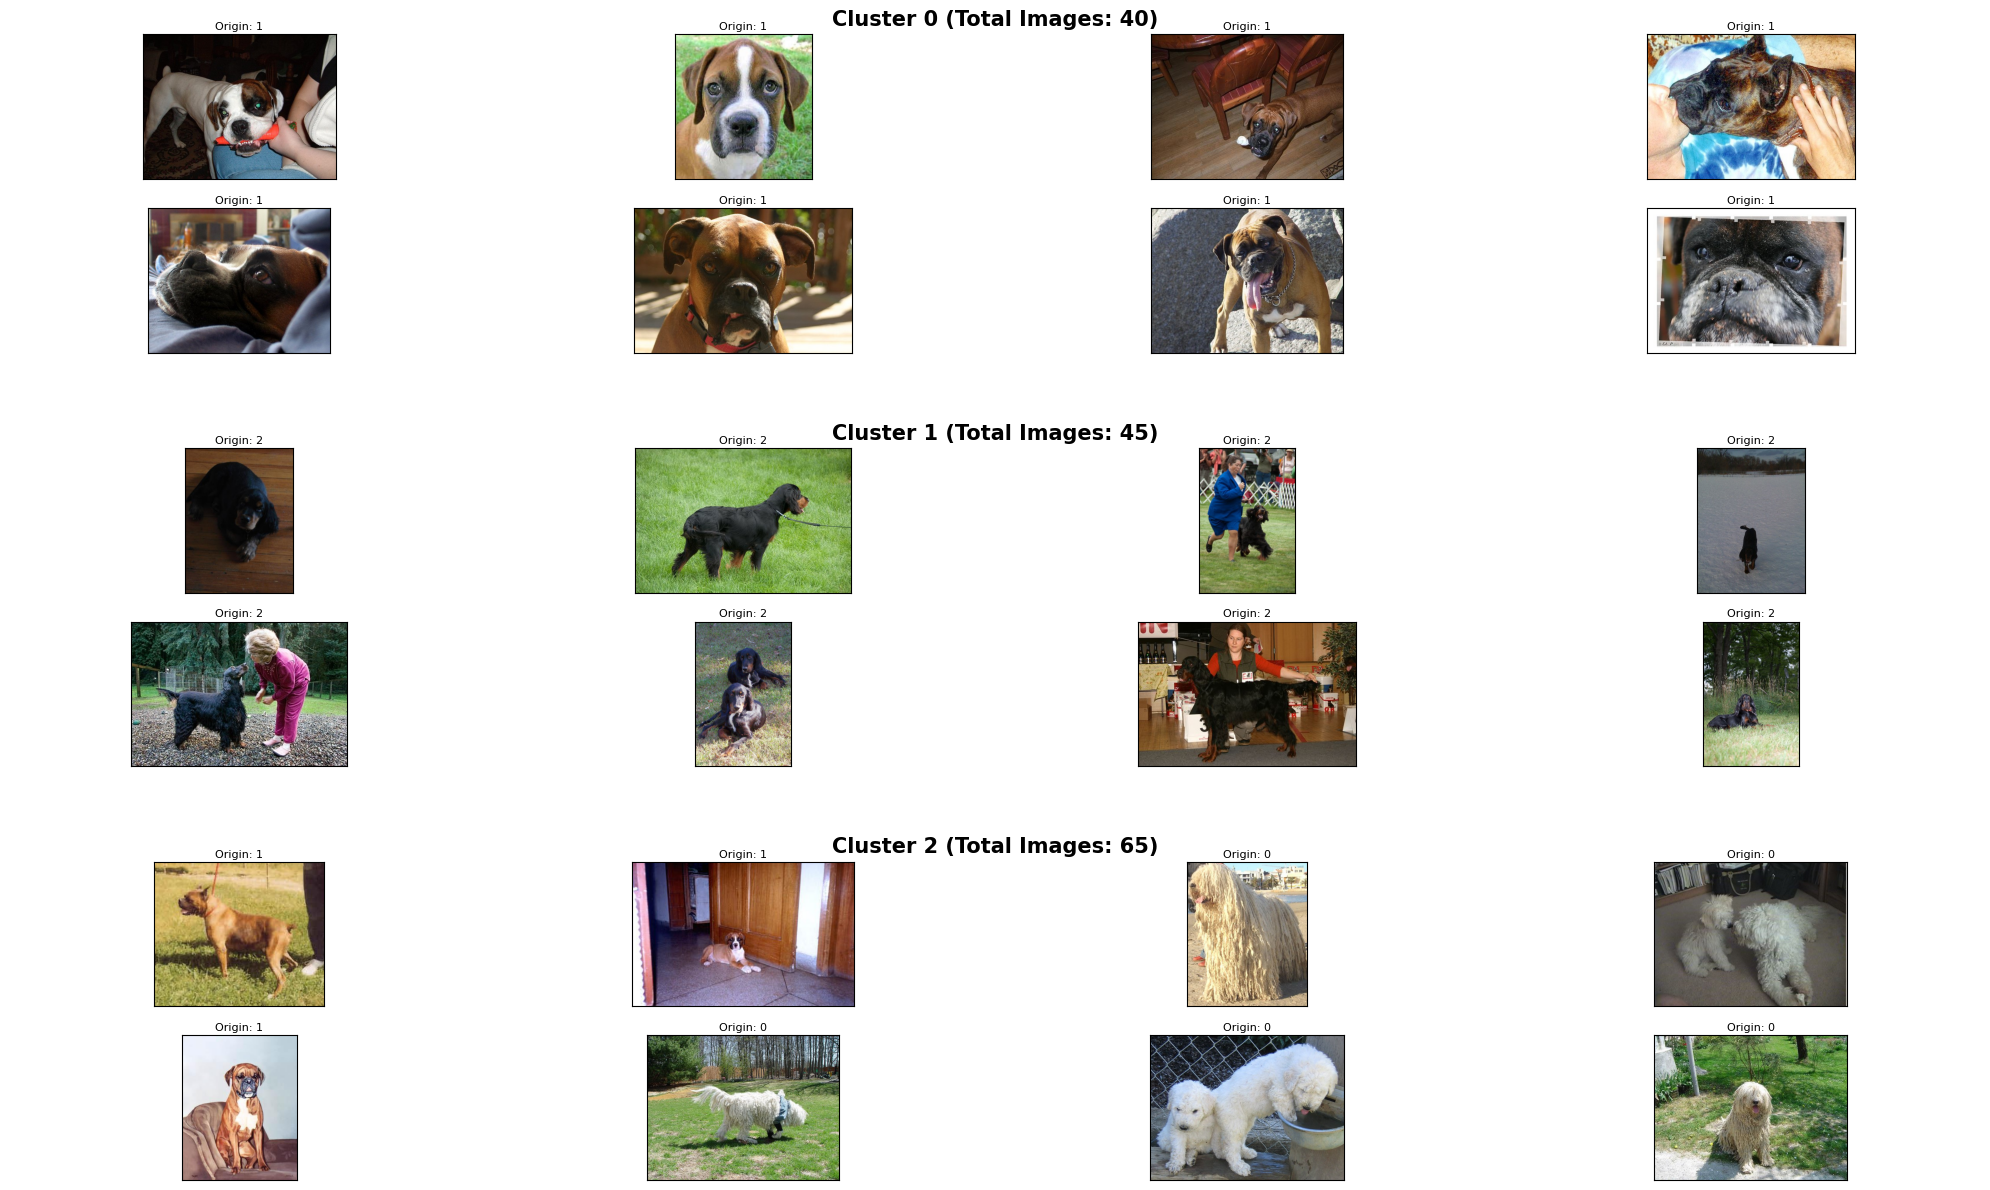

In [14]:
visualize_cluster_samples(metadata)